### Earliest Deadline First (EDF) - Dynamic Priority Scheduling Algorithm

- Selection Function: 
    - Earliest Deadline => Highest Priority
- Decision Mode:
    - Preemtive
- Task properties:
    - Periodic (T)
    - Deadline (D); D = T
    - Worst Case Execution Time (C), C <= D
    - Tasks are independent
    
### Schedulability Tests
- nSufficient and necessary condition:
    - sum(Ci/Ti)<=1

#### Author: Sharath Lokesh

In [1]:
# imports
import matplotlib.pyplot as plt
from math import gcd
import pandas as pd

In [2]:
def compute_hyper_period(T):
    """ This function computes the hyper period of the taskset, i.e. LCM of the time periods."""
    hyper_period = 1
    for t in T:
        hyper_period = (hyper_period * t) // gcd(hyper_period, t) #compute LCM
    print("\nHyper-Period:", hyper_period)
    return hyper_period

In [3]:
def schedulability_test(C, T):
    """ Test for EDF scheduliability"""
    ret_val = True
    
    utilization = 0
    for c, t in zip(C, T):
        utilization = utilization + (c/t)
        
    print("Utilization: ", round(utilization,4))
    if (utilization > 1):
        ret_val = False
        print("Utilization is > 1. Therefore the task set is not schedulable.\n")
        
    else:
        print("Necessary and sufficient contdition passed: Task set is schedulable.\n")
        
    return ret_val

In [4]:
def prepare_tasket(C, T):
    """ Function to prepare the taskset as pandas data-frame"""
    # create a sample dataframe
    task_names = ["T"+str(i) for i in range(len(C))]
    priority = [i+1 for i in range(len(C))] #fixed priority

    #data frame
    df = pd.DataFrame({
        'Task-Name': task_names,
        'WCET': C,
        'Time-Period': T,
        'Pending-Scheduling': C,
        'Deadline': T
    })
    
    print("Given Task-set\n"+ "-"*80)
    print(df.to_string(index=False))
    
    return df

In [5]:
def get_task(task_set):
    """Function to get the next schedulable task"""
    # Filter tasks with non-zero pending execution time
    schedulable_tasks = task_set[task_set["Pending-Scheduling"] > 0]
    
    # If no tasks are schedulable, return None
    if schedulable_tasks.empty:
        return None
    
    # Sort tasks by priority (high priority - earlisest deadline)
    sorted_tasks = schedulable_tasks.sort_values(by=["Deadline"])
    next_task = sorted_tasks.iloc[0]
    
    return next_task["Task-Name"]

In [6]:
def update_task_set(task_set, current_time):
    """Update the taskset after scheduling a task/ job"""
    
    if current_time == 0:
        return task_set
    # assign the WCET if the task is available (multiple of the task time period) 
    for task_name, row in task_set.iterrows():
        period = row["Time-Period"]
        if current_time % period == 0:
            task_set.loc[task_name, "Pending-Scheduling"] += row["WCET"]
    
    return task_set

In [7]:
def gantt_chart(schedule, hyper_period, task_set):
    """ Graphical represntation of RMS schedule """
    fig, gnt = plt.subplots(figsize=(3*len(set(schedule)), len(set(schedule))))
    gnt.set_xlim(0, hyper_period)
    
    gnt.set_xlabel('Time')
    gnt.set_ylabel('Task')
    gnt.set_xticks(range(len(schedule)+1))
    gnt.set_xticklabels(range(len(schedule)+1))
    
    y_ticks_label = {}
    init_val = 5
    count=0
    deadline_ptr = 1/len(set(schedule))
    for tsk, row in task_set.iterrows():
        y_ticks_label[row["Task-Name"]] = (init_val + count * len(set(schedule)))
        count += 1
        
        # mark deadlines on gantt chart
        task = row["Task-Name"]
        for i in range(hyper_period+1):
            if ((i%row["Time-Period"]) == 0):
                gnt.scatter(i, y_ticks_label[task], marker='o', color='red', alpha = 0.75, linewidths=0.5)
                
            
    
    gnt.set_yticks(list(y_ticks_label.values()))
    gnt.set_yticklabels(list(y_ticks_label.keys()))
    gnt.grid(True, linestyle='--', alpha=0.6)
    
    task_quantum_time = 1
    height = 1
    for i, task in enumerate(schedule):
        if (task==None):
            continue
        gnt.broken_barh([(i,task_quantum_time)], (y_ticks_label[task], height))

In [8]:
def earliest_deadline_first_scheduling(C, T):
    """ Implemetation of RMS algortithm """
    ret_val = False
    if len(C) != len(T):
        return print("Array size of Worst Case Execution Time (C) and Time Period (T) must be equal.\n")
    
    print("Schedulability Test")
    print("*"*40)
    
    ret_val = schedulability_test(C, T)
    if (True == ret_val):
        schedule = []
        task_set = prepare_tasket(C,T)
        hyp_period = compute_hyper_period(T)
        print("*"*20)
        print("Schedule")
        print("*"*20)
        for i in range(hyp_period):
            task = get_task(task_set)
            print(i, task, sep="\t")
            schedule.append(task)
            task_set.loc[task_set["Task-Name"] == task, "Pending-Scheduling"] -= 1
            
            if (task !=None) and ((task_set.loc[task_set["Task-Name"] == task, "Pending-Scheduling"].iloc[0]) == 0):
                task_set.loc[task_set["Task-Name"] == task, "Deadline"] += task_set.loc[task_set["Task-Name"] == task, "Time-Period"]
            task_set = update_task_set(task_set,i+1)
        gantt_chart(schedule, hyp_period, task_set)

Schedulability Test
****************************************
Utilization:  0.85
Necessary and sufficient contdition passed: Task set is schedulable.

Given Task-set
--------------------------------------------------------------------------------
Task-Name  WCET  Time-Period  Pending-Scheduling  Deadline
       T0     2            5                   2         5
       T1     2            8                   2         8
       T2     2           10                   2        10

Hyper-Period: 40
********************
Schedule
********************
0	T0
1	T0
2	T1
3	T1
4	T2
5	T0
6	T0
7	T2
8	T1
9	T1
10	T0
11	T0
12	T2
13	T2
14	None
15	T0
16	T0
17	T1
18	T1
19	None
20	T0
21	T0
22	T2
23	T2
24	T1
25	T0
26	T0
27	T1
28	None
29	None
30	T0
31	T0
32	T1
33	T1
34	T2
35	T0
36	T0
37	T2
38	None
39	None


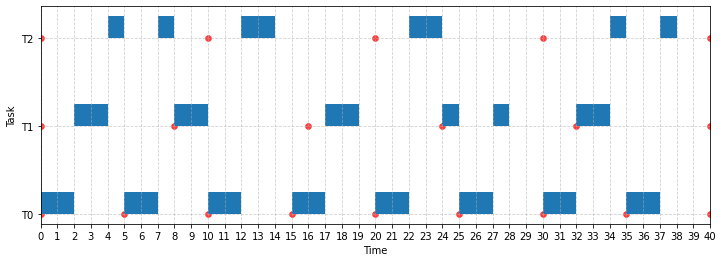

In [9]:
# Example 1
C = [2, 2, 2]
T = [5, 8, 10]
earliest_deadline_first_scheduling(C, T)

Schedulability Test
****************************************
Utilization:  0.9333
Necessary and sufficient contdition passed: Task set is schedulable.

Given Task-set
--------------------------------------------------------------------------------
Task-Name  WCET  Time-Period  Pending-Scheduling  Deadline
       T0     2            5                   2         5
       T1     1            3                   1         3
       T2     2           10                   2        10

Hyper-Period: 30
********************
Schedule
********************
0	T1
1	T0
2	T0
3	T1
4	T2
5	T0
6	T1
7	T0
8	T2
9	T1
10	T0
11	T0
12	T1
13	T2
14	T2
15	T1
16	T0
17	T0
18	T1
19	None
20	T0
21	T1
22	T0
23	T2
24	T1
25	T0
26	T0
27	T1
28	T2
29	None


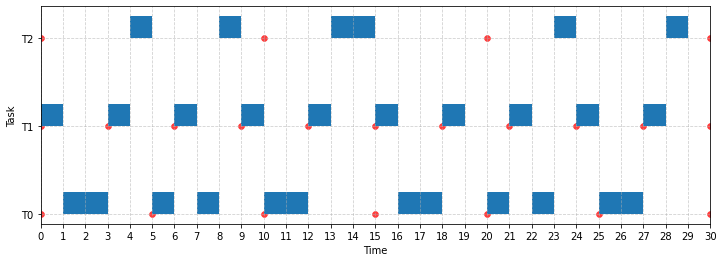

In [10]:
# Example 2
C = [2, 1, 2]
T = [5, 3, 10]
earliest_deadline_first_scheduling(C, T)

Schedulability Test
****************************************
Utilization:  0.775
Necessary and sufficient contdition passed: Task set is schedulable.

Given Task-set
--------------------------------------------------------------------------------
Task-Name  WCET  Time-Period  Pending-Scheduling  Deadline
       T0     2            5                   2         5
       T1     3            8                   3         8

Hyper-Period: 40
********************
Schedule
********************
0	T0
1	T0
2	T1
3	T1
4	T1
5	T0
6	T0
7	None
8	T1
9	T1
10	T0
11	T0
12	T1
13	None
14	None
15	T0
16	T0
17	T1
18	T1
19	T1
20	T0
21	T0
22	None
23	None
24	T1
25	T0
26	T0
27	T1
28	T1
29	None
30	T0
31	T0
32	T1
33	T1
34	T1
35	T0
36	T0
37	None
38	None
39	None


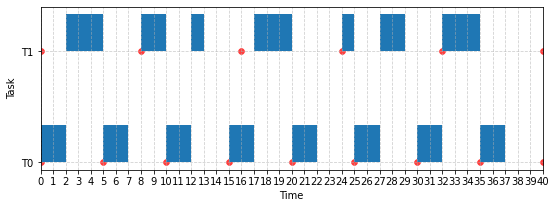

In [11]:
# Example 3
C = [2, 3]
T = [5, 8]
earliest_deadline_first_scheduling(C, T)